In [1]:
import itertools
import pandas as pd
import utils
from collections import defaultdict, OrderedDict
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.sparse import hstack, vstack
import tensorflow as tf
from nn_models import TextCNN, TextCNN_field_aware, TextRNN, TextRNN_field_aware, TextRNN_attention
import data_helpers
import os
import time
import datetime
import pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
ORDERED_NAMES = [u'study',
                 u'history',
                 u'comparison',
                 u'technique',
                 u'findings',
                 u'impression', 
                 u'signed by',
                 ]

--------
# Read data

In [3]:
filename = 'Data/upto1528.xlsx'
df_raw = pd.read_excel(open(filename, 'rb'))

In [ ]:
# Data is stored in df
ps = utils.Parser()
ps.parse(df_raw)
df = ps.df
for idx, row in df['findings'].items():
    try:
        text, velos = utils.parse_findings(row)
        df.at[idx, 'findings'] = text
        for n, v in velos:
            df.at[0, n] = v
    except:
        pass
discardField = ['Report Text']
foo = [item for item in df.columns.tolist() if item not in ORDERED_NAMES + discardField]
foo.sort()
CORE_COL = ORDERED_NAMES + foo
df = df[CORE_COL]
df = pd.concat([df_raw[['Past', 'Present', 'Left', 'Right', 'Count']], df[CORE_COL]], axis=1)
# turn null to []
df = utils.null2empty(df, ['history', 'impression', 'comparison'])

# Add Grade
df.loc[df['Left'].isnull(), 'Left'] = 0
df.loc[df['Left']==4, 'Left'] = 0.5

df.loc[df['Right'].isnull(), 'Right'] = 0
df.loc[df['Right']==4, 'Right'] = 0.5

df['Grade'] = df[['Left', 'Right']].max(axis=1)
df.loc[df['Grade']==0.5, 'Grade'] = 4
df['Grade'] = df['Grade'].astype('int')

print(df.shape)

In [ ]:
FIELDS = [
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
df = df[['Past', 'Present', 'Grade'] + FIELDS]
df_processed = utils.Dataframe_Proc.strs2str(df, FIELDS)

In [ ]:
df_processed.columns

In [ ]:
# Save
pickle.dump(df_processed, open('Data/DataFrame_processed.p', 'wb'))

In [4]:
# Load
df_processed = pickle.load(open('Data/DataFrame_processed.p', 'rb'))

---
# Data Prep

In [51]:
TO_PREDICT = 'Grade'
FIELDS = [
    'history',
    'findings',
    'comparison',
    'impression',
#     'Grade',
#     'Present',
#     'Past'
]

# df_filtered = df_processed[~df_processed[TO_PREDICT].isnull() & (df_processed[TO_PREDICT] != 0)].sample(frac=1, random_state=1)
df_filtered = df_processed[~df_processed[TO_PREDICT].isnull()].sample(frac=1, random_state=1)
df_filtered = df_filtered[[TO_PREDICT] + FIELDS]

df_train = df_filtered.iloc[:1220]
y_train = np.array(df_train[TO_PREDICT].astype(int))
enc = LabelEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train)

df_test = df_filtered.iloc[1220:]
y_test = np.array(df_test[TO_PREDICT].astype(int))
y_test = enc.transform(y_test)

print(df_train.shape)
print(df_test.shape)
df_filtered[TO_PREDICT].value_counts()

(1220, 5)
(307, 5)


0    1139
1     166
2     103
3      69
4      50
Name: Grade, dtype: int64

---
# Tranditional ML

### TFIDF features

In [ ]:
ngram, min_count = 5, 5

obj = utils.Df2TFIDF()
obj.fit(df_train, ngram=ngram, min_count=min_count)
output_train = obj.transform(df_train)
output_test = obj.transform(df_test)
# concatenate sparse matrices of all fields
x_train = hstack([foo['bow_tfidf'] for foo in output_train.values()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.values()])

print(x_train.shape)
print(x_test.shape)

### Run classifier

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
# svm
# clf = LinearSVC(C=1, loss='squared_hinge')
#clf = SVC()
clf = LogisticRegression(C=3)

clf.fit(x_train, y_train)
coef = clf.coef_.squeeze()

In [ ]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
results = pd.concat([utils.my_classification_report(y_train, y_train_pred),
                     utils.my_classification_report(y_test, y_test_pred),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)

In [ ]:
# features with the big weights
idx = np.absolute(coef).argsort()[::-1]
plt.plot(coef[idx])
plt.show()
idx2word_agg = pd.Series(obj.idx2word_concat)
display(idx2word_agg[idx[:20]])

In [ ]:
# output failed cases.
pd.set_option('display.max_colwidth', -1)
false_positive = (y_test_pred - y_test) > 0
display(df_test.loc[false_positive,:].applymap(utils.list2str))

---
---
# Neural Nets

**Data Prep**

In [5]:
df_train.columns

Index(['Grade', 'history', 'findings', 'comparison', 'impression'], dtype='object')

In [6]:
maxlen = [100,
          125,
          50,
          100]

In [7]:
x_train_text = utils.Dataframe_Proc.df2text(df_train, df_train.columns[1:])
word2idx, idx2word = utils.Text_Proc.ngram_vocab_processor(x_train_text, ngram=1, min_count=2)
x_train = np.array(utils.Text_Proc.encode_texts(x_train_text, word2idx, maxlen=sum(maxlen)))

enc = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(y_train[:, None])

x_dev_text = utils.Dataframe_Proc.df2text(df_test, df_test.columns[1:])
x_dev = np.array(utils.Text_Proc.encode_texts(x_dev_text, word2idx, maxlen=x_train.shape[1]))

y_dev = enc.transform(y_test[:, None])

### NN Models

In [8]:
# Both CNN and RNN
tf.flags.DEFINE_integer("embedding_dim", 64, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularization lambda (default: 0.0)")

# CNN parameter
tf.flags.DEFINE_string("filter_sizes", "3,4", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 64, "Number of filters per filter size (default: 128)")

# RNN parameter
tf.flags.DEFINE_integer('hidden_size', 64, 'Hidden size of LSTM')
tf.flags.DEFINE_integer('num_layers', 1, 'Number of LSTM layers')

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 200, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")


Parameters:
ALLOW_SOFT_PLACEMENT=True
BATCH_SIZE=64
CHECKPOINT_EVERY=100
DROPOUT_KEEP_PROB=0.5
EMBEDDING_DIM=64
EVALUATE_EVERY=100
FILTER_SIZES=3,4
HIDDEN_SIZE=64
L2_REG_LAMBDA=0.0
LOG_DEVICE_PLACEMENT=False
NUM_CHECKPOINTS=5
NUM_EPOCHS=200
NUM_FILTERS=64
NUM_LAYERS=1



In [9]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        # model = TextCNN(
        #     sequence_length=x_train.shape[1],
        #     num_classes=y_train.shape[1],
        #     vocab_size=len(word2idx),
        #     embedding_size=FLAGS.embedding_dim,
        #     filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
        #     num_filters=FLAGS.num_filters,
        #     l2_reg_lambda=FLAGS.l2_reg_lambda)

        # model = TextCNN_field_aware(sequence_lengths=maxlen,
        #                             num_classes=y_train.shape[1],
        #                             vocab_size=len(word2idx),
        #                             embedding_size=FLAGS.embedding_dim,
        #                             filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
        #                             num_filters=FLAGS.num_filters,
        #                             l2_reg_lambda=FLAGS.l2_reg_lambda)

        # model = TextRNN(sequence_length=sum(maxlen),
        #                 num_classes=y_train.shape[1],
        #                 vocab_size=len(word2idx),
        #                 embedding_size=FLAGS.embedding_dim,
        #                 hidden_size=FLAGS.hidden_size,
        #                 num_layers=FLAGS.num_layers,
        #                 l2_reg_lambda=FLAGS.l2_reg_lambda)

        # model = TextRNN_field_aware(sequence_lengths=maxlen,
        #                             num_classes=y_train.shape[1],
        #                             vocab_size=len(word2idx),
        #                             embedding_size=FLAGS.embedding_dim,
        #                             hidden_size=FLAGS.hidden_size,
        #                             num_layers=FLAGS.num_layers,
        #                             l2_reg_lambda=FLAGS.l2_reg_lambda)

        model = TextRNN_attention(sequence_length=sum(maxlen),
                        num_classes=y_train.shape[1],
                        vocab_size=len(word2idx),
                        embedding_size=FLAGS.embedding_dim,
                        hidden_size=FLAGS.hidden_size,
                        num_layers=FLAGS.num_layers,
                        l2_reg_lambda=FLAGS.l2_reg_lambda)


        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        # optimizer = tf.train.GradientDescentOptimizer(1e-3)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(model.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))

        if 'CNN' in model.__class__.__name__:
            name = "CNN_{}_{}_".format(FLAGS.embedding_dim, FLAGS.num_filters)
        elif 'RNN' in model.__class__.__name__:
            name = "RNN_{}_{}_{}_".format(FLAGS.embedding_dim, FLAGS.hidden_size, FLAGS.num_layers)


        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", name + timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", model.loss)
        acc_summary = tf.summary.scalar("accuracy", model.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

        # Write vocabulary
        # vocab_processor.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
                model.input_x: x_batch,
                model.input_y: y_batch,
                model.dropout_keep_prob: FLAGS.dropout_keep_prob,
                model.batch_size: len(x_batch)
            }

            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, model.loss, model.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
                model.input_x: x_batch,
                model.input_y: y_batch,
                model.dropout_keep_prob: 1.0,
                model.batch_size: len(x_batch)
            }

            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, model.loss, model.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        # Generate batches
        batches = data_helpers.batch_iter(
            list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)

            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % FLAGS.evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % FLAGS.checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

        #
        feed_dict = {
            model.input_x: x_dev,
            model.input_y: y_dev,
            model.dropout_keep_prob: 1.0,
            model.batch_size: len(x_dev)
        }
        y_pred, alpha = sess.run([model.predictions, model.alpha], feed_dict=feed_dict)

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name RNN/multi_rnn_cell/cell_0/lstm_cell/kernel:0/grad/hist is illegal; using RNN/multi_rnn_cell/cell_0/lstm_cell/kernel_0/grad/hist instead.
INFO:tensorflow:Summary name RNN/multi_rnn_cell/cell_0/lstm_cell/kernel:0/grad/sparsity is illegal; using RNN/multi_rnn_cell/cell_0/lstm_cell/kernel_0/grad/sparsity instead.
INFO:tensorflow:Summary name RNN/multi_rnn_cell/cell_0/lstm_cell/bias:0/grad/hist is illegal; using RNN/multi_rnn_cell/cell_0/lstm_cell/bias_0/grad/hist instead.
INFO:tensorflow:Summary name RNN/multi_rnn_cell/cell_0/lstm_cell/bias:0/grad/sparsity is illegal; using RNN/multi_rnn_cell/cell_0/lstm_cell/bias_0/grad/sparsity instead.
INFO:tensorflow:Summary name Attention/W:0/grad/hist is illegal; using Attention/W_0/grad/hist instead.
INFO:ten

2018-06-05T18:27:14.339082: step 104, loss 0.77048, acc 0.75
2018-06-05T18:27:14.503209: step 105, loss 0.803944, acc 0.75
2018-06-05T18:27:14.665295: step 106, loss 0.499231, acc 0.828125
2018-06-05T18:27:14.828464: step 107, loss 0.901042, acc 0.703125
2018-06-05T18:27:14.995422: step 108, loss 0.860497, acc 0.703125
2018-06-05T18:27:15.152553: step 109, loss 0.849564, acc 0.71875
2018-06-05T18:27:15.316068: step 110, loss 0.667995, acc 0.78125
2018-06-05T18:27:15.478840: step 111, loss 0.774246, acc 0.6875
2018-06-05T18:27:15.640949: step 112, loss 0.742553, acc 0.6875
2018-06-05T18:27:15.801539: step 113, loss 0.672261, acc 0.765625
2018-06-05T18:27:15.963913: step 114, loss 0.703742, acc 0.734375
2018-06-05T18:27:16.130135: step 115, loss 0.82682, acc 0.703125
2018-06-05T18:27:16.288011: step 116, loss 0.807915, acc 0.703125
2018-06-05T18:27:16.444622: step 117, loss 0.791161, acc 0.71875
2018-06-05T18:27:16.608424: step 118, loss 0.593364, acc 0.8125
2018-06-05T18:27:16.769844: s

2018-06-05T18:27:35.574076: step 228, loss 0.405444, acc 0.828125
2018-06-05T18:27:35.734672: step 229, loss 0.7937, acc 0.671875
2018-06-05T18:27:35.894063: step 230, loss 0.69807, acc 0.71875
2018-06-05T18:27:36.055290: step 231, loss 0.381719, acc 0.875
2018-06-05T18:27:36.218280: step 232, loss 0.562996, acc 0.78125
2018-06-05T18:27:36.378319: step 233, loss 0.607339, acc 0.765625
2018-06-05T18:27:36.538948: step 234, loss 0.421752, acc 0.828125
2018-06-05T18:27:36.701008: step 235, loss 0.365164, acc 0.859375
2018-06-05T18:27:36.859750: step 236, loss 0.593277, acc 0.796875
2018-06-05T18:27:37.023371: step 237, loss 0.339067, acc 0.890625
2018-06-05T18:27:37.178910: step 238, loss 0.491369, acc 0.828125
2018-06-05T18:27:37.345253: step 239, loss 0.704994, acc 0.75
2018-06-05T18:27:37.494003: step 240, loss 0.459926, acc 0.75
2018-06-05T18:27:37.653706: step 241, loss 0.60287, acc 0.765625
2018-06-05T18:27:37.824789: step 242, loss 0.888712, acc 0.671875
2018-06-05T18:27:37.985519:

2018-06-05T18:27:56.748519: step 352, loss 0.453578, acc 0.796875
2018-06-05T18:27:56.914693: step 353, loss 0.358611, acc 0.859375
2018-06-05T18:27:57.073095: step 354, loss 0.456367, acc 0.859375
2018-06-05T18:27:57.235084: step 355, loss 0.504978, acc 0.78125
2018-06-05T18:27:57.395637: step 356, loss 0.343042, acc 0.890625
2018-06-05T18:27:57.557420: step 357, loss 0.512729, acc 0.796875
2018-06-05T18:27:57.722262: step 358, loss 0.317903, acc 0.875
2018-06-05T18:27:57.881249: step 359, loss 0.560529, acc 0.796875
2018-06-05T18:27:58.031131: step 360, loss 0.265561, acc 1
2018-06-05T18:27:58.190472: step 361, loss 0.316117, acc 0.90625
2018-06-05T18:27:58.352503: step 362, loss 0.582529, acc 0.796875
2018-06-05T18:27:58.501950: step 363, loss 0.285508, acc 0.9375
2018-06-05T18:27:58.662504: step 364, loss 0.582216, acc 0.796875
2018-06-05T18:27:58.828222: step 365, loss 0.604382, acc 0.8125
2018-06-05T18:27:58.994584: step 366, loss 0.216835, acc 0.921875
2018-06-05T18:27:59.151884

2018-06-05T18:28:18.065504: step 476, loss 0.433407, acc 0.859375
2018-06-05T18:28:18.223338: step 477, loss 0.396521, acc 0.84375
2018-06-05T18:28:18.384771: step 478, loss 0.335732, acc 0.859375
2018-06-05T18:28:18.546998: step 479, loss 0.401886, acc 0.78125
2018-06-05T18:28:18.692489: step 480, loss 0.404211, acc 1
2018-06-05T18:28:18.856863: step 481, loss 0.373688, acc 0.84375
2018-06-05T18:28:19.025953: step 482, loss 0.486643, acc 0.8125
2018-06-05T18:28:19.183069: step 483, loss 0.271306, acc 0.90625
2018-06-05T18:28:19.338139: step 484, loss 0.543022, acc 0.78125
2018-06-05T18:28:19.504085: step 485, loss 0.346854, acc 0.890625
2018-06-05T18:28:19.671416: step 486, loss 0.219387, acc 0.890625
2018-06-05T18:28:19.835095: step 487, loss 0.416233, acc 0.796875
2018-06-05T18:28:19.998322: step 488, loss 0.363186, acc 0.828125
2018-06-05T18:28:20.163090: step 489, loss 0.3099, acc 0.859375
2018-06-05T18:28:20.325916: step 490, loss 0.229259, acc 0.875
2018-06-05T18:28:20.491363: s

2018-06-05T18:28:39.279773: step 600, loss 0.164924, acc 1

Evaluation:
2018-06-05T18:28:39.340340: step 600, loss 0.510791, acc 0.820847

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/RNN_64_64_1_1528248406/checkpoints/model-600

2018-06-05T18:28:40.706598: step 601, loss 0.256461, acc 0.90625
2018-06-05T18:28:40.866279: step 602, loss 0.306009, acc 0.859375
2018-06-05T18:28:41.034226: step 603, loss 0.315481, acc 0.9375
2018-06-05T18:28:41.198533: step 604, loss 0.261851, acc 0.859375
2018-06-05T18:28:41.362960: step 605, loss 0.276218, acc 0.875
2018-06-05T18:28:41.520725: step 606, loss 0.179841, acc 0.9375
2018-06-05T18:28:41.682852: step 607, loss 0.343122, acc 0.828125
2018-06-05T18:28:41.847667: step 608, loss 0.185834, acc 0.9375
2018-06-05T18:28:42.015390: step 609, loss 0.2057, acc 0.953125
2018-06-05T18:28:42.177867: step 610, loss 0.302704, acc 0.921875
2018-06-05T18:28:42.334044: step 611, loss 0.240695, acc 0.875
2018-06-05T18:28:42.496344: step 6

2018-06-05T18:29:01.550267: step 722, loss 0.207885, acc 0.9375
2018-06-05T18:29:01.706664: step 723, loss 0.165994, acc 0.953125
2018-06-05T18:29:01.868944: step 724, loss 0.235536, acc 0.890625
2018-06-05T18:29:02.025570: step 725, loss 0.251962, acc 0.9375
2018-06-05T18:29:02.189865: step 726, loss 0.304256, acc 0.9375
2018-06-05T18:29:02.350570: step 727, loss 0.197891, acc 0.921875
2018-06-05T18:29:02.509520: step 728, loss 0.158372, acc 0.96875
2018-06-05T18:29:02.671295: step 729, loss 0.193285, acc 0.9375
2018-06-05T18:29:02.832200: step 730, loss 0.192085, acc 0.953125
2018-06-05T18:29:02.994449: step 731, loss 0.200931, acc 0.9375
2018-06-05T18:29:03.158861: step 732, loss 0.290878, acc 0.9375
2018-06-05T18:29:03.319207: step 733, loss 0.279304, acc 0.90625
2018-06-05T18:29:03.474741: step 734, loss 0.205813, acc 0.9375
2018-06-05T18:29:03.630109: step 735, loss 0.334898, acc 0.875
2018-06-05T18:29:03.790919: step 736, loss 0.281049, acc 0.921875
2018-06-05T18:29:03.951247: s

2018-06-05T18:29:22.700815: step 846, loss 0.194668, acc 0.9375
2018-06-05T18:29:22.868797: step 847, loss 0.19481, acc 0.953125
2018-06-05T18:29:23.029877: step 848, loss 0.165653, acc 0.96875
2018-06-05T18:29:23.194261: step 849, loss 0.174595, acc 0.953125
2018-06-05T18:29:23.367459: step 850, loss 0.214058, acc 0.9375
2018-06-05T18:29:23.522625: step 851, loss 0.136301, acc 0.953125
2018-06-05T18:29:23.681386: step 852, loss 0.173496, acc 0.9375
2018-06-05T18:29:23.855335: step 853, loss 0.265691, acc 0.921875
2018-06-05T18:29:24.026180: step 854, loss 0.156434, acc 0.953125
2018-06-05T18:29:24.185608: step 855, loss 0.158691, acc 0.96875
2018-06-05T18:29:24.346264: step 856, loss 0.16906, acc 0.9375
2018-06-05T18:29:24.504419: step 857, loss 0.400275, acc 0.921875
2018-06-05T18:29:24.659936: step 858, loss 0.311454, acc 0.890625
2018-06-05T18:29:24.830338: step 859, loss 0.288086, acc 0.890625
2018-06-05T18:29:24.983723: step 860, loss 0.00760942, acc 1
2018-06-05T18:29:25.147768:

2018-06-05T18:29:44.077289: step 970, loss 0.0695326, acc 0.984375
2018-06-05T18:29:44.243081: step 971, loss 0.176939, acc 0.953125
2018-06-05T18:29:44.405174: step 972, loss 0.140916, acc 0.9375
2018-06-05T18:29:44.561909: step 973, loss 0.168501, acc 0.9375
2018-06-05T18:29:44.725124: step 974, loss 0.0953538, acc 0.96875
2018-06-05T18:29:44.879206: step 975, loss 0.122424, acc 0.96875
2018-06-05T18:29:45.036630: step 976, loss 0.381796, acc 0.890625
2018-06-05T18:29:45.200056: step 977, loss 0.0887768, acc 0.984375
2018-06-05T18:29:45.366760: step 978, loss 0.0926685, acc 0.984375
2018-06-05T18:29:45.527247: step 979, loss 0.0535523, acc 1
2018-06-05T18:29:45.674774: step 980, loss 0.0777004, acc 1
2018-06-05T18:29:45.830845: step 981, loss 0.126405, acc 0.953125
2018-06-05T18:29:45.986183: step 982, loss 0.116542, acc 0.96875
2018-06-05T18:29:46.147825: step 983, loss 0.152372, acc 0.9375
2018-06-05T18:29:46.307944: step 984, loss 0.21397, acc 0.9375
2018-06-05T18:29:46.472622: st

2018-06-05T18:30:05.258745: step 1094, loss 0.146277, acc 0.953125
2018-06-05T18:30:05.420361: step 1095, loss 0.0633042, acc 0.984375
2018-06-05T18:30:05.581148: step 1096, loss 0.162273, acc 0.953125
2018-06-05T18:30:05.742248: step 1097, loss 0.125021, acc 0.96875
2018-06-05T18:30:05.906201: step 1098, loss 0.13638, acc 0.953125
2018-06-05T18:30:06.067912: step 1099, loss 0.261784, acc 0.890625
2018-06-05T18:30:06.214474: step 1100, loss 0.0885849, acc 1

Evaluation:
2018-06-05T18:30:06.271993: step 1100, loss 0.531083, acc 0.856678

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/RNN_64_64_1_1528248406/checkpoints/model-1100

2018-06-05T18:30:07.720859: step 1101, loss 0.168785, acc 0.953125
2018-06-05T18:30:07.886771: step 1102, loss 0.0339084, acc 1
2018-06-05T18:30:08.055078: step 1103, loss 0.197113, acc 0.953125
2018-06-05T18:30:08.214967: step 1104, loss 0.309629, acc 0.9375
2018-06-05T18:30:08.380601: step 1105, loss 0.118922, acc 0.953125
2018-06-05T18

2018-06-05T18:30:26.870324: step 1212, loss 0.0701591, acc 0.984375
2018-06-05T18:30:27.029601: step 1213, loss 0.0526672, acc 0.984375
2018-06-05T18:30:27.192038: step 1214, loss 0.140486, acc 0.921875
2018-06-05T18:30:27.348090: step 1215, loss 0.366671, acc 0.921875
2018-06-05T18:30:27.513256: step 1216, loss 0.123051, acc 0.953125
2018-06-05T18:30:27.673367: step 1217, loss 0.0785816, acc 0.984375
2018-06-05T18:30:27.835097: step 1218, loss 0.0838228, acc 0.96875
2018-06-05T18:30:27.998610: step 1219, loss 0.142255, acc 0.953125
2018-06-05T18:30:28.146370: step 1220, loss 0.00171499, acc 1
2018-06-05T18:30:28.305586: step 1221, loss 0.0508795, acc 0.984375
2018-06-05T18:30:28.467712: step 1222, loss 0.222949, acc 0.90625
2018-06-05T18:30:28.630349: step 1223, loss 0.0871825, acc 0.96875
2018-06-05T18:30:28.795996: step 1224, loss 0.101949, acc 0.96875
2018-06-05T18:30:28.959221: step 1225, loss 0.0901339, acc 0.953125
2018-06-05T18:30:29.118327: step 1226, loss 0.0836831, acc 0.968

2018-06-05T18:30:48.242100: step 1334, loss 0.0332994, acc 1
2018-06-05T18:30:48.398269: step 1335, loss 0.340925, acc 0.921875
2018-06-05T18:30:48.565261: step 1336, loss 0.223111, acc 0.921875
2018-06-05T18:30:48.730558: step 1337, loss 0.231117, acc 0.890625
2018-06-05T18:30:48.887677: step 1338, loss 0.0333875, acc 1
2018-06-05T18:30:49.061837: step 1339, loss 0.119632, acc 0.96875
2018-06-05T18:30:49.206416: step 1340, loss 0.088429, acc 1
2018-06-05T18:30:49.361719: step 1341, loss 0.0347354, acc 1
2018-06-05T18:30:49.523972: step 1342, loss 0.108166, acc 0.96875
2018-06-05T18:30:49.686124: step 1343, loss 0.11594, acc 0.96875
2018-06-05T18:30:49.850716: step 1344, loss 0.093698, acc 0.96875
2018-06-05T18:30:50.011898: step 1345, loss 0.190271, acc 0.96875
2018-06-05T18:30:50.182752: step 1346, loss 0.0801773, acc 0.96875
2018-06-05T18:30:50.353589: step 1347, loss 0.443703, acc 0.890625
2018-06-05T18:30:50.512171: step 1348, loss 0.104743, acc 0.96875
2018-06-05T18:30:50.674483:

2018-06-05T18:31:09.139307: step 1456, loss 0.0982998, acc 0.953125
2018-06-05T18:31:09.315032: step 1457, loss 0.11564, acc 0.984375
2018-06-05T18:31:09.480017: step 1458, loss 0.0467841, acc 1
2018-06-05T18:31:09.647803: step 1459, loss 0.0398621, acc 1
2018-06-05T18:31:09.800620: step 1460, loss 0.00215012, acc 1
2018-06-05T18:31:09.968045: step 1461, loss 0.0748758, acc 0.984375
2018-06-05T18:31:10.127462: step 1462, loss 0.129224, acc 0.953125
2018-06-05T18:31:10.284514: step 1463, loss 0.0444544, acc 0.984375
2018-06-05T18:31:10.445913: step 1464, loss 0.0326877, acc 0.984375
2018-06-05T18:31:10.609314: step 1465, loss 0.0653997, acc 0.984375
2018-06-05T18:31:10.772599: step 1466, loss 0.288631, acc 0.9375
2018-06-05T18:31:10.927614: step 1467, loss 0.0385238, acc 0.984375
2018-06-05T18:31:11.090187: step 1468, loss 0.034402, acc 0.984375
2018-06-05T18:31:11.250347: step 1469, loss 0.0282553, acc 1
2018-06-05T18:31:11.405377: step 1470, loss 0.0759567, acc 0.953125
2018-06-05T18:

2018-06-05T18:31:29.930069: step 1578, loss 0.0545514, acc 0.984375
2018-06-05T18:31:30.093928: step 1579, loss 0.0766147, acc 0.96875
2018-06-05T18:31:30.248289: step 1580, loss 0.00125757, acc 1
2018-06-05T18:31:30.418197: step 1581, loss 0.196101, acc 0.9375
2018-06-05T18:31:30.588800: step 1582, loss 0.0757449, acc 0.984375
2018-06-05T18:31:30.749312: step 1583, loss 0.110418, acc 0.953125
2018-06-05T18:31:30.902390: step 1584, loss 0.0776664, acc 0.984375
2018-06-05T18:31:31.071396: step 1585, loss 0.0184147, acc 1
2018-06-05T18:31:31.224785: step 1586, loss 0.082516, acc 0.984375
2018-06-05T18:31:31.377076: step 1587, loss 0.0405448, acc 0.984375
2018-06-05T18:31:31.556347: step 1588, loss 0.125182, acc 0.953125
2018-06-05T18:31:31.719479: step 1589, loss 0.130548, acc 0.96875
2018-06-05T18:31:31.886434: step 1590, loss 0.175634, acc 0.921875
2018-06-05T18:31:32.044149: step 1591, loss 0.0253774, acc 1
2018-06-05T18:31:32.212864: step 1592, loss 0.070555, acc 0.984375
2018-06-05T

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/RNN_64_64_1_1528248406/checkpoints/model-1700

2018-06-05T18:31:52.325992: step 1701, loss 0.0327456, acc 1
2018-06-05T18:31:52.480473: step 1702, loss 0.0315497, acc 0.984375
2018-06-05T18:31:52.640053: step 1703, loss 0.0425891, acc 0.984375
2018-06-05T18:31:52.811077: step 1704, loss 0.026933, acc 1
2018-06-05T18:31:52.979037: step 1705, loss 0.13386, acc 0.953125
2018-06-05T18:31:53.137463: step 1706, loss 0.0156498, acc 1
2018-06-05T18:31:53.300876: step 1707, loss 0.0285487, acc 1
2018-06-05T18:31:53.460106: step 1708, loss 0.0634897, acc 0.96875
2018-06-05T18:31:53.619234: step 1709, loss 0.0163987, acc 1
2018-06-05T18:31:53.782694: step 1710, loss 0.0612369, acc 0.96875
2018-06-05T18:31:53.943865: step 1711, loss 0.0358884, acc 1
2018-06-05T18:31:54.106548: step 1712, loss 0.0172402, acc 1
2018-06-05T18:31:54.262991: step 1713, loss 0.0582204, acc 0.984375
2018-06-05T18:31:54.422567: step 1714, loss 0.0650496

2018-06-05T18:32:13.090507: step 1822, loss 0.074438, acc 0.984375
2018-06-05T18:32:13.246418: step 1823, loss 0.14808, acc 0.96875
2018-06-05T18:32:13.409626: step 1824, loss 0.142189, acc 0.953125
2018-06-05T18:32:13.568601: step 1825, loss 0.0546776, acc 0.984375
2018-06-05T18:32:13.732441: step 1826, loss 0.100015, acc 0.96875
2018-06-05T18:32:13.895106: step 1827, loss 0.211379, acc 0.96875
2018-06-05T18:32:14.059934: step 1828, loss 0.114616, acc 0.953125
2018-06-05T18:32:14.220734: step 1829, loss 0.153328, acc 0.96875
2018-06-05T18:32:14.378228: step 1830, loss 0.129402, acc 0.9375
2018-06-05T18:32:14.534845: step 1831, loss 0.0247467, acc 1
2018-06-05T18:32:14.690705: step 1832, loss 0.126056, acc 0.96875
2018-06-05T18:32:14.854530: step 1833, loss 0.107927, acc 0.96875
2018-06-05T18:32:15.014431: step 1834, loss 0.0288415, acc 0.984375
2018-06-05T18:32:15.173774: step 1835, loss 0.0352329, acc 1
2018-06-05T18:32:15.333821: step 1836, loss 0.0856758, acc 0.953125
2018-06-05T18

2018-06-05T18:32:34.150593: step 1944, loss 0.0923273, acc 0.953125
2018-06-05T18:32:34.305237: step 1945, loss 0.0413566, acc 0.984375
2018-06-05T18:32:34.468035: step 1946, loss 0.193593, acc 0.953125
2018-06-05T18:32:34.628263: step 1947, loss 0.0445418, acc 1
2018-06-05T18:32:34.787395: step 1948, loss 0.0316639, acc 1
2018-06-05T18:32:34.946498: step 1949, loss 0.0575562, acc 0.96875
2018-06-05T18:32:35.116920: step 1950, loss 0.0536434, acc 0.984375
2018-06-05T18:32:35.278398: step 1951, loss 0.0591439, acc 0.96875
2018-06-05T18:32:35.443150: step 1952, loss 0.108637, acc 0.953125
2018-06-05T18:32:35.599048: step 1953, loss 0.0420296, acc 1
2018-06-05T18:32:35.762162: step 1954, loss 0.148193, acc 0.953125
2018-06-05T18:32:35.924403: step 1955, loss 0.067826, acc 0.984375
2018-06-05T18:32:36.084257: step 1956, loss 0.238458, acc 0.96875
2018-06-05T18:32:36.246534: step 1957, loss 0.109969, acc 0.953125
2018-06-05T18:32:36.407159: step 1958, loss 0.0661821, acc 0.96875
2018-06-05T

2018-06-05T18:32:55.452258: step 2068, loss 0.0430105, acc 0.984375
2018-06-05T18:32:55.612778: step 2069, loss 0.0196359, acc 1
2018-06-05T18:32:55.769265: step 2070, loss 0.0437066, acc 0.984375
2018-06-05T18:32:55.931767: step 2071, loss 0.0548363, acc 0.984375
2018-06-05T18:32:56.093364: step 2072, loss 0.244832, acc 0.953125
2018-06-05T18:32:56.260560: step 2073, loss 0.00720588, acc 1
2018-06-05T18:32:56.425433: step 2074, loss 0.0213181, acc 1
2018-06-05T18:32:56.582416: step 2075, loss 0.0989634, acc 0.96875
2018-06-05T18:32:56.738023: step 2076, loss 0.0172528, acc 1
2018-06-05T18:32:56.899468: step 2077, loss 0.0349538, acc 1
2018-06-05T18:32:57.061553: step 2078, loss 0.0370162, acc 1
2018-06-05T18:32:57.218339: step 2079, loss 0.0379592, acc 1
2018-06-05T18:32:57.361797: step 2080, loss 0.0204388, acc 1
2018-06-05T18:32:57.521745: step 2081, loss 0.0129344, acc 1
2018-06-05T18:32:57.683599: step 2082, loss 0.111134, acc 0.953125
2018-06-05T18:32:57.844172: step 2083, loss 0

2018-06-05T18:33:17.107012: step 2196, loss 0.0457091, acc 1
2018-06-05T18:33:17.266592: step 2197, loss 0.00456623, acc 1
2018-06-05T18:33:17.420434: step 2198, loss 0.0205638, acc 1
2018-06-05T18:33:17.581582: step 2199, loss 0.0473426, acc 0.984375
2018-06-05T18:33:17.728419: step 2200, loss 0.00215009, acc 1

Evaluation:
2018-06-05T18:33:17.788260: step 2200, loss 0.646772, acc 0.892508

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/RNN_64_64_1_1528248406/checkpoints/model-2200

2018-06-05T18:33:19.170823: step 2201, loss 0.0177365, acc 1
2018-06-05T18:33:19.327246: step 2202, loss 0.0218267, acc 1
2018-06-05T18:33:19.492111: step 2203, loss 0.0152235, acc 1
2018-06-05T18:33:19.655229: step 2204, loss 0.00481238, acc 1
2018-06-05T18:33:19.816570: step 2205, loss 0.019775, acc 1
2018-06-05T18:33:19.975013: step 2206, loss 0.00526069, acc 1
2018-06-05T18:33:20.132573: step 2207, loss 0.018846, acc 1
2018-06-05T18:33:20.290220: step 2208, loss 0.0294035, acc 1


2018-06-05T18:33:39.351021: step 2320, loss 0.00400043, acc 1
2018-06-05T18:33:39.510025: step 2321, loss 0.0108929, acc 1
2018-06-05T18:33:39.668582: step 2322, loss 0.032628, acc 1
2018-06-05T18:33:39.824933: step 2323, loss 0.191424, acc 0.984375
2018-06-05T18:33:39.987254: step 2324, loss 0.0175164, acc 1
2018-06-05T18:33:40.148263: step 2325, loss 0.136762, acc 0.984375
2018-06-05T18:33:40.313378: step 2326, loss 0.131208, acc 0.984375
2018-06-05T18:33:40.476131: step 2327, loss 0.103218, acc 0.984375
2018-06-05T18:33:40.635459: step 2328, loss 0.114636, acc 0.96875
2018-06-05T18:33:40.794137: step 2329, loss 0.0648324, acc 0.984375
2018-06-05T18:33:40.951294: step 2330, loss 0.0374444, acc 0.96875
2018-06-05T18:33:41.112410: step 2331, loss 0.0983407, acc 0.984375
2018-06-05T18:33:41.271500: step 2332, loss 0.0434318, acc 0.984375
2018-06-05T18:33:41.430948: step 2333, loss 0.101502, acc 0.984375
2018-06-05T18:33:41.589510: step 2334, loss 0.0775083, acc 0.96875
2018-06-05T18:33:

2018-06-05T18:34:00.386343: step 2444, loss 0.0396547, acc 1
2018-06-05T18:34:00.548101: step 2445, loss 0.014, acc 1
2018-06-05T18:34:00.700759: step 2446, loss 0.0440648, acc 0.984375
2018-06-05T18:34:00.855553: step 2447, loss 0.0310418, acc 1
2018-06-05T18:34:01.013434: step 2448, loss 0.0384967, acc 0.984375
2018-06-05T18:34:01.174843: step 2449, loss 0.0710324, acc 0.984375
2018-06-05T18:34:01.330912: step 2450, loss 0.0305339, acc 1
2018-06-05T18:34:01.489998: step 2451, loss 0.213395, acc 0.984375
2018-06-05T18:34:01.647435: step 2452, loss 0.0316958, acc 1
2018-06-05T18:34:01.807385: step 2453, loss 0.121234, acc 0.96875
2018-06-05T18:34:01.970614: step 2454, loss 0.035803, acc 1
2018-06-05T18:34:02.132617: step 2455, loss 0.0229178, acc 1
2018-06-05T18:34:02.294789: step 2456, loss 0.0203161, acc 1
2018-06-05T18:34:02.457375: step 2457, loss 0.0260012, acc 0.984375
2018-06-05T18:34:02.614898: step 2458, loss 0.181935, acc 0.953125
2018-06-05T18:34:02.771418: step 2459, loss 0

2018-06-05T18:34:22.033123: step 2572, loss 0.0118506, acc 1
2018-06-05T18:34:22.197447: step 2573, loss 0.0117177, acc 1
2018-06-05T18:34:22.361180: step 2574, loss 0.0107328, acc 1
2018-06-05T18:34:22.517939: step 2575, loss 0.0155195, acc 1
2018-06-05T18:34:22.681471: step 2576, loss 0.0379412, acc 0.984375
2018-06-05T18:34:22.843271: step 2577, loss 0.0203784, acc 0.984375
2018-06-05T18:34:22.999670: step 2578, loss 0.00659462, acc 1
2018-06-05T18:34:23.155636: step 2579, loss 0.274076, acc 0.96875
2018-06-05T18:34:23.300153: step 2580, loss 0.00318401, acc 1
2018-06-05T18:34:23.460493: step 2581, loss 0.00770174, acc 1
2018-06-05T18:34:23.624318: step 2582, loss 0.00916873, acc 1
2018-06-05T18:34:23.782979: step 2583, loss 0.0123784, acc 1
2018-06-05T18:34:23.944132: step 2584, loss 0.155739, acc 0.96875
2018-06-05T18:34:24.104597: step 2585, loss 0.00964816, acc 1
2018-06-05T18:34:24.266685: step 2586, loss 0.0084253, acc 1
2018-06-05T18:34:24.432386: step 2587, loss 0.0414849, a

2018-06-05T18:34:43.674962: step 2700, loss 0.0244682, acc 1

Evaluation:
2018-06-05T18:34:43.736801: step 2700, loss 0.732395, acc 0.876221

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/RNN_64_64_1_1528248406/checkpoints/model-2700

2018-06-05T18:34:45.128655: step 2701, loss 0.0933307, acc 0.96875
2018-06-05T18:34:45.292991: step 2702, loss 0.0053907, acc 1
2018-06-05T18:34:45.451559: step 2703, loss 0.00777803, acc 1
2018-06-05T18:34:45.611929: step 2704, loss 0.00906279, acc 1
2018-06-05T18:34:45.768524: step 2705, loss 0.0168478, acc 1
2018-06-05T18:34:45.925621: step 2706, loss 0.00957439, acc 1
2018-06-05T18:34:46.091531: step 2707, loss 0.0180937, acc 1
2018-06-05T18:34:46.252090: step 2708, loss 0.00576473, acc 1
2018-06-05T18:34:46.409929: step 2709, loss 0.00748394, acc 1
2018-06-05T18:34:46.566543: step 2710, loss 0.0220729, acc 1
2018-06-05T18:34:46.728157: step 2711, loss 0.00309657, acc 1
2018-06-05T18:34:46.884205: step 2712, loss 0.00271115, ac

2018-06-05T18:35:06.353312: step 2826, loss 0.00486946, acc 1
2018-06-05T18:35:06.517089: step 2827, loss 0.00637585, acc 1
2018-06-05T18:35:06.681158: step 2828, loss 0.0104535, acc 1
2018-06-05T18:35:06.844932: step 2829, loss 0.00241769, acc 1
2018-06-05T18:35:07.004386: step 2830, loss 0.00464684, acc 1
2018-06-05T18:35:07.158455: step 2831, loss 0.00565519, acc 1
2018-06-05T18:35:07.314905: step 2832, loss 0.00290333, acc 1
2018-06-05T18:35:07.475532: step 2833, loss 0.00417678, acc 1
2018-06-05T18:35:07.635241: step 2834, loss 0.00581134, acc 1
2018-06-05T18:35:07.795479: step 2835, loss 0.00233619, acc 1
2018-06-05T18:35:07.957554: step 2836, loss 0.0130007, acc 1
2018-06-05T18:35:08.118149: step 2837, loss 0.177213, acc 0.984375
2018-06-05T18:35:08.274110: step 2838, loss 0.0119245, acc 1
2018-06-05T18:35:08.429064: step 2839, loss 0.00721516, acc 1
2018-06-05T18:35:08.572885: step 2840, loss 0.0021056, acc 1
2018-06-05T18:35:08.728911: step 2841, loss 0.00383263, acc 1
2018-06

2018-06-05T18:35:27.853237: step 2952, loss 0.623795, acc 0.875
2018-06-05T18:35:28.017102: step 2953, loss 0.634985, acc 0.84375
2018-06-05T18:35:28.177365: step 2954, loss 0.61333, acc 0.84375
2018-06-05T18:35:28.340487: step 2955, loss 0.764899, acc 0.734375
2018-06-05T18:35:28.500699: step 2956, loss 0.71699, acc 0.828125
2018-06-05T18:35:28.662095: step 2957, loss 0.618131, acc 0.890625
2018-06-05T18:35:28.824822: step 2958, loss 0.436891, acc 0.9375
2018-06-05T18:35:28.981114: step 2959, loss 0.394053, acc 0.921875
2018-06-05T18:35:29.129067: step 2960, loss 0.661751, acc 0.75
2018-06-05T18:35:29.286937: step 2961, loss 0.409441, acc 0.921875
2018-06-05T18:35:29.446991: step 2962, loss 0.387859, acc 0.890625
2018-06-05T18:35:29.602936: step 2963, loss 0.377865, acc 0.921875
2018-06-05T18:35:29.759186: step 2964, loss 0.398837, acc 0.875
2018-06-05T18:35:29.920030: step 2965, loss 0.55037, acc 0.8125
2018-06-05T18:35:30.079770: step 2966, loss 0.475403, acc 0.875
2018-06-05T18:35:

2018-06-05T18:35:48.582512: step 3074, loss 0.1996, acc 0.96875
2018-06-05T18:35:48.740507: step 3075, loss 0.432895, acc 0.828125
2018-06-05T18:35:48.902102: step 3076, loss 0.107199, acc 0.984375
2018-06-05T18:35:49.058768: step 3077, loss 0.233123, acc 0.953125
2018-06-05T18:35:49.220752: step 3078, loss 0.216776, acc 0.921875
2018-06-05T18:35:49.382206: step 3079, loss 0.25575, acc 0.890625
2018-06-05T18:35:49.530904: step 3080, loss 0.025183, acc 1
2018-06-05T18:35:49.692164: step 3081, loss 0.219262, acc 0.921875
2018-06-05T18:35:49.852607: step 3082, loss 0.30501, acc 0.890625
2018-06-05T18:35:50.007569: step 3083, loss 0.205135, acc 0.9375
2018-06-05T18:35:50.165699: step 3084, loss 0.0949842, acc 0.953125
2018-06-05T18:35:50.323473: step 3085, loss 0.183836, acc 0.96875
2018-06-05T18:35:50.481536: step 3086, loss 0.378149, acc 0.890625
2018-06-05T18:35:50.638931: step 3087, loss 0.2482, acc 0.953125
2018-06-05T18:35:50.799278: step 3088, loss 0.364565, acc 0.9375
2018-06-05T18

2018-06-05T18:36:09.248890: step 3196, loss 0.22441, acc 0.953125
2018-06-05T18:36:09.410672: step 3197, loss 0.079925, acc 0.984375
2018-06-05T18:36:09.569370: step 3198, loss 0.178172, acc 0.96875
2018-06-05T18:36:09.726788: step 3199, loss 0.261144, acc 0.953125
2018-06-05T18:36:09.878682: step 3200, loss 0.0176623, acc 1

Evaluation:
2018-06-05T18:36:09.937875: step 3200, loss 0.436802, acc 0.859935

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/RNN_64_64_1_1528248406/checkpoints/model-3200

2018-06-05T18:36:11.311393: step 3201, loss 0.150339, acc 0.9375
2018-06-05T18:36:11.469865: step 3202, loss 0.293026, acc 0.890625
2018-06-05T18:36:11.628343: step 3203, loss 0.11047, acc 0.953125
2018-06-05T18:36:11.789063: step 3204, loss 0.159657, acc 0.953125
2018-06-05T18:36:11.948581: step 3205, loss 0.252647, acc 0.9375
2018-06-05T18:36:12.115783: step 3206, loss 0.135671, acc 0.96875
2018-06-05T18:36:12.277527: step 3207, loss 0.226909, acc 0.9375
2018-06-05T18:

2018-06-05T18:36:30.933891: step 3316, loss 0.0574092, acc 0.984375
2018-06-05T18:36:31.098779: step 3317, loss 0.122772, acc 0.953125
2018-06-05T18:36:31.263460: step 3318, loss 0.143759, acc 0.953125
2018-06-05T18:36:31.421083: step 3319, loss 0.0541708, acc 1
2018-06-05T18:36:31.567222: step 3320, loss 0.00491722, acc 1
2018-06-05T18:36:31.726862: step 3321, loss 0.0962319, acc 0.96875
2018-06-05T18:36:31.891307: step 3322, loss 0.0785539, acc 0.984375
2018-06-05T18:36:32.054899: step 3323, loss 0.0380613, acc 0.984375
2018-06-05T18:36:32.214292: step 3324, loss 0.109222, acc 0.96875
2018-06-05T18:36:32.371518: step 3325, loss 0.0474582, acc 1
2018-06-05T18:36:32.533619: step 3326, loss 0.112877, acc 0.96875
2018-06-05T18:36:32.692544: step 3327, loss 0.297708, acc 0.90625
2018-06-05T18:36:32.851854: step 3328, loss 0.122978, acc 0.96875
2018-06-05T18:36:33.014659: step 3329, loss 0.110572, acc 0.953125
2018-06-05T18:36:33.172770: step 3330, loss 0.0375978, acc 0.984375
2018-06-05T1

2018-06-05T18:36:51.912056: step 3440, loss 0.0101555, acc 1
2018-06-05T18:36:52.070907: step 3441, loss 0.0243292, acc 1
2018-06-05T18:36:52.238503: step 3442, loss 0.0807995, acc 0.984375
2018-06-05T18:36:52.395676: step 3443, loss 0.0782657, acc 1
2018-06-05T18:36:52.556511: step 3444, loss 0.0702767, acc 0.984375
2018-06-05T18:36:52.721794: step 3445, loss 0.0430852, acc 0.984375
2018-06-05T18:36:52.879778: step 3446, loss 0.0282831, acc 1
2018-06-05T18:36:53.042943: step 3447, loss 0.0956971, acc 0.984375
2018-06-05T18:36:53.205214: step 3448, loss 0.0580151, acc 0.96875
2018-06-05T18:36:53.357964: step 3449, loss 0.0446998, acc 1
2018-06-05T18:36:53.517378: step 3450, loss 0.0752307, acc 0.96875
2018-06-05T18:36:53.675706: step 3451, loss 0.177405, acc 0.96875
2018-06-05T18:36:53.832706: step 3452, loss 0.0651959, acc 0.984375
2018-06-05T18:36:53.994282: step 3453, loss 0.121231, acc 0.984375
2018-06-05T18:36:54.154411: step 3454, loss 0.102829, acc 0.96875
2018-06-05T18:36:54.31

2018-06-05T18:37:12.953466: step 3564, loss 0.0910984, acc 0.984375
2018-06-05T18:37:13.119083: step 3565, loss 0.0339777, acc 0.984375
2018-06-05T18:37:13.272613: step 3566, loss 0.0668125, acc 0.984375
2018-06-05T18:37:13.435353: step 3567, loss 0.0570301, acc 0.984375
2018-06-05T18:37:13.594017: step 3568, loss 0.0199011, acc 1
2018-06-05T18:37:13.749871: step 3569, loss 0.0132887, acc 1
2018-06-05T18:37:13.909036: step 3570, loss 0.122576, acc 0.984375
2018-06-05T18:37:14.075506: step 3571, loss 0.0324606, acc 1
2018-06-05T18:37:14.236258: step 3572, loss 0.0853135, acc 0.984375
2018-06-05T18:37:14.400580: step 3573, loss 0.0216529, acc 1
2018-06-05T18:37:14.563335: step 3574, loss 0.0298454, acc 0.984375
2018-06-05T18:37:14.726502: step 3575, loss 0.0173531, acc 1
2018-06-05T18:37:14.885334: step 3576, loss 0.0516909, acc 0.984375
2018-06-05T18:37:15.049006: step 3577, loss 0.0208239, acc 1
2018-06-05T18:37:15.204547: step 3578, loss 0.0354703, acc 0.984375
2018-06-05T18:37:15.362

2018-06-05T18:37:34.350642: step 3690, loss 0.0406406, acc 0.984375
2018-06-05T18:37:34.506032: step 3691, loss 0.0978696, acc 0.96875
2018-06-05T18:37:34.662067: step 3692, loss 0.025382, acc 0.984375
2018-06-05T18:37:34.813968: step 3693, loss 0.0138214, acc 1
2018-06-05T18:37:34.965481: step 3694, loss 0.226446, acc 0.96875
2018-06-05T18:37:35.128215: step 3695, loss 0.0556016, acc 0.96875
2018-06-05T18:37:35.286525: step 3696, loss 0.0252292, acc 0.984375
2018-06-05T18:37:35.444296: step 3697, loss 0.0534832, acc 0.984375
2018-06-05T18:37:35.605943: step 3698, loss 0.0467944, acc 0.96875
2018-06-05T18:37:35.761493: step 3699, loss 0.0118157, acc 1
2018-06-05T18:37:35.902896: step 3700, loss 0.00234899, acc 1

Evaluation:
2018-06-05T18:37:35.961802: step 3700, loss 0.584009, acc 0.869707

Saved model checkpoint to /home/vzhao/Documents/Projects/Med-NLP/runs/RNN_64_64_1_1528248406/checkpoints/model-3700

2018-06-05T18:37:37.330460: step 3701, loss 0.0979788, acc 0.96875
2018-06-05T18

2018-06-05T18:37:56.559751: step 3814, loss 0.0199883, acc 1
2018-06-05T18:37:56.717995: step 3815, loss 0.0154858, acc 1
2018-06-05T18:37:56.875980: step 3816, loss 0.0373478, acc 0.984375
2018-06-05T18:37:57.041679: step 3817, loss 0.0127766, acc 1
2018-06-05T18:37:57.195765: step 3818, loss 0.0314273, acc 1
2018-06-05T18:37:57.354687: step 3819, loss 0.0519765, acc 0.984375
2018-06-05T18:37:57.499413: step 3820, loss 0.00328615, acc 1
2018-06-05T18:37:57.656072: step 3821, loss 0.00937276, acc 1
2018-06-05T18:37:57.816826: step 3822, loss 0.0083681, acc 1
2018-06-05T18:37:57.972819: step 3823, loss 0.0053448, acc 1
2018-06-05T18:37:58.134962: step 3824, loss 0.0117164, acc 1
2018-06-05T18:37:58.290817: step 3825, loss 0.176669, acc 0.953125
2018-06-05T18:37:58.446423: step 3826, loss 0.0130764, acc 1
2018-06-05T18:37:58.608129: step 3827, loss 0.0705283, acc 0.984375
2018-06-05T18:37:58.772549: step 3828, loss 0.0303308, acc 0.984375
2018-06-05T18:37:58.932739: step 3829, loss 0.141

2018-06-05T18:38:17.560302: step 3938, loss 0.0955712, acc 0.96875
2018-06-05T18:38:17.719070: step 3939, loss 0.111827, acc 0.953125
2018-06-05T18:38:17.866842: step 3940, loss 1.48186, acc 0.75
2018-06-05T18:38:18.025826: step 3941, loss 0.0724753, acc 0.96875
2018-06-05T18:38:18.188873: step 3942, loss 0.0678866, acc 0.984375
2018-06-05T18:38:18.348017: step 3943, loss 0.12811, acc 0.96875
2018-06-05T18:38:18.509422: step 3944, loss 0.0825455, acc 0.984375
2018-06-05T18:38:18.672625: step 3945, loss 0.139519, acc 0.96875
2018-06-05T18:38:18.831675: step 3946, loss 0.108757, acc 0.96875
2018-06-05T18:38:18.990740: step 3947, loss 0.0647897, acc 0.984375
2018-06-05T18:38:19.148220: step 3948, loss 0.151215, acc 0.9375
2018-06-05T18:38:19.308540: step 3949, loss 0.101542, acc 0.984375
2018-06-05T18:38:19.466576: step 3950, loss 0.073663, acc 0.984375
2018-06-05T18:38:19.626353: step 3951, loss 0.163055, acc 0.96875
2018-06-05T18:38:19.783545: step 3952, loss 0.137055, acc 0.96875
2018-

In [10]:
alpha.shape

(307, 375, 1)

In [11]:
alpha[5,:,0].sum()

1.0

In [12]:
y_test

array([1, 0, 0, 0, 1, 2, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2,
       0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 3, 0, 3, 0, 2, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2,
       1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 4, 2, 4, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 4, 1, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0,
       0, 4, 1, 0, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 4, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 2,

In [38]:
y_test[21]

2

In [40]:
x_dev[21,:]

array([ 74,   2,   4, 180, 193,  27,   5,  25,  50,  63,   3,   1,  74,
         2,  14,  20,  70,   3,   1,   7,   6,   2,  10,  24,   2,  54,
        28,  33,  39,  11,  49,  17,  48,   1,  37,  17,  12,   8,   1,
         9,  13,  21,  29,   1,  37,  17,  12,   8,   1,   7,  13,  21,
        29,  24,  18,  14,  28,  31,  26,  96, 118, 129, 109, 221,  20,
       127, 129,   0,  22,  69,  97,  88,   4,   3,   1,   9,  30,   6,
         2,  10,   4,   3,   1,   7,   6,   2,  10,  44,   3,   6,   2,
         4,   5,  42,   8,  43,  23,  32,  38,  22,  47,  11,  34,  36,
       183,  76, 777, 778, 779, 192,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [41]:
' '.join(utils.Text_Proc.decode_texts(x_dev[21,:],idx2word))

'bilateral carotid stenosis followup exam there is significant atherosclerotic disease of the bilateral carotid arteries and tortuosity of the left internal carotid artery both carotid systems demonstrate normal waveforms with brisk systolic upstrokes the peak systolic velocities on the right are as follows the peak systolic velocities on the left are as follows both vertebral arteries demonstrate antegrade flow ultrasound study dated cta head and neck dated UNK to or greater than stenosis of the right proximal internal carotid artery stenosis of the left internal carotid artery analysis of internal carotid stenosis is based on duplex doppler velocity parameters to correlate with nascet criteria reported by krystal c buchanan md UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK U

In [24]:
alpha[5,:,0]

0.059910815

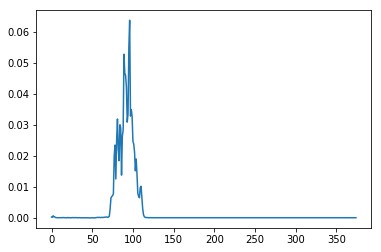

In [42]:
plt.plot(alpha[21,:,0])

In [43]:
' '.join(map(str, list(alpha[21,:,0])))

'0.00034540019 0.000260408 0.0007415851 0.00038187584 0.00036587083 0.00019054399 0.00012626407 0.00014300297 0.00011078269 0.00012080636 0.00014913164 0.00013718441 0.00013723245 0.00012024797 0.00015793655 0.00015806041 0.0001071577 0.00013776693 0.00013203545 9.1998336e-05 0.00016547299 0.00011623464 0.00013756023 9.885877e-05 0.00010564301 0.00012284813 0.00015540095 0.00012745714 0.00014493197 0.00013612093 0.00015205522 0.00012531327 0.00010779653 0.00013040146 0.00014031249 0.0001114249 8.312398e-05 9.137646e-05 0.0001063023 0.0001032055 0.00010476618 0.00011277188 6.629694e-05 0.00010423872 9.978009e-05 9.98452e-05 5.3796837e-05 6.7902205e-05 8.69941e-05 6.43398e-05 8.3708896e-05 9.8814475e-05 6.2228675e-05 5.456377e-05 0.00012123963 0.00014722647 0.00014477034 0.00023089777 0.00018439903 0.00022310433 0.00017470983 0.00021915852 0.00022035341 0.0001833317 0.00024071634 0.000258818 0.00029631637 0.00032006152 0.00036190602 0.0002198489 0.0003287138 0.0006241656 0.0030382972 0.0

In [48]:
df_test.iloc[5,:]['impression']

'extensive hyperechoic plaque at the left bifurcation and bulb with hemodynamically significant stenosis of probably just over  no other hemodynamically significant stenosis within the bilateral carotid systems analysis of internal carotid stenosis is based on duplex doppler velocity parameters that correlate with the calculation of an internal carotid artery stenosis according to the nascet criteria'

In [ ]:
from collections import Counter
Counter(y_pred[y_test==4])

---------

## Classification Model

## Use findings and impression to predict present and pass

In [ ]:
df['history'][1]

In [ ]:
#for PAST without inconsistency
fields = [
    'history', 
    'findings', 
    'comparison', 
    'impression',
]
foo = df[~df['Past'].isnull() & df['Count'] != 1].sample(frac=1)
df_train = foo.iloc[:1240]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[1240:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for PRESENT
fields = [
    'history', 
    'findings', 
    'comparison',
    'impression',
]
#'history', 'impression', 'findings', 'comparison'
foo = df[~df['Present'].isnull()].sample(frac=1)
foo = foo.loc[foo['Present']!=0, :]
df_train = foo.iloc[:1100]
y_train = np.array(df_train['Present'].astype(int))
df_test = foo.iloc[1100:]
y_test = np.array(df_test['Present'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=2)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for Left Grade
fields = ['history', 'findings', 'comparison','impression']
foo = df[~df['Left'].isnull() & df['Left'] != 0].sample(frac=1)
df_train = foo.iloc[:210]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[210:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)

# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for Left Grade
fields = ['history', 'findings', 'comparison','impression']
foo = df[~df['Right'].isnull() & df['Right'] != 0].sample(frac=1)
df_train = foo.iloc[:200]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[200:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)

# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

### run classifier

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
# svm
clf = LinearSVC(C=1, loss='squared_hinge')
#clf = SVC()
#clf = LogisticRegression(C=3)

clf.fit(x_train, y_train)
coef = clf.coef_.squeeze()

In [ ]:
x_train.shape

In [ ]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
results = pd.concat([utils.my_classification_report(y_train, y_train_pred),
                     utils.my_classification_report(y_test, y_test_pred),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)

In [ ]:
# features with the big weights
idx = np.absolute(coef).argsort()[::-1]
plt.plot(coef[idx])
plt.show()
idx2word_agg = pd.Series(obj.idx2word_concat)
display(idx2word_agg[idx[:20]])

In [ ]:
# output failed cases.
pd.set_option('display.max_colwidth', -1)
fields = [
    'Past',
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
false_positive = (y_test_pred - y_test) > 0
display(df_test.loc[false_positive,fields].applymap(utils.list2str))

---
# Semi - Supervised Learning

## Prepare data

### Labeled Data

In [ ]:
filename = 'Data/upto1528.xlsx'
df_raw = pd.read_excel(open(filename, 'r'))
# get data frame
ps = utils.Parser()
ps.parser(df_raw)
df = ps.df
for idx, row in df['findings'].iteritems():
    try:
        text, velos = utils.parse_findings(row)
        df.set_value(idx, 'findings', text)
        for n, v in velos:
            df.set_value(idx, n, v)
    except:
        pass
discardField = ['Report Text']
foo = [item for item in df.columns.tolist() if item not in ORDERED_NAMES + discardField]
foo.sort()
CORE_COL = ORDERED_NAMES + foo
df = df[CORE_COL]
df_labeled = pd.concat([df_raw[['Past', 'Present', 'Left', 'Right', 'Count']], df[CORE_COL]], axis=1)

### Unlabeled Data

In [ ]:
filename = 'Data/2011-2016.xlsx'
df_raw = pd.read_excel(open(filename, 'r'))
# get data frame
ps = utils.Parser()
ps.parser(df_raw)
df = ps.df
for idx, row in df['findings'].iteritems():
    try:
        text, velos = utils.parse_findings(row)
        df.set_value(idx, 'findings', text)
        for n, v in velos:
            df.set_value(idx, n, v)
    except:
        pass
discardField = ['Report Text']
foo = [item for item in df.columns.tolist() if item not in ORDERED_NAMES + discardField]
foo.sort()
CORE_COL = ORDERED_NAMES + foo
df_unlabeled = df[CORE_COL]
# df = pd.concat([df_raw[['Past', 'Present', 'Left', 'Right', 'Count']], df[CORE_COL]], axis=1)

----

In [ ]:
#for PAST
fields = [
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
# labeled data
df_labeled = utils.null2empty(df_labeled, fields)
foo = df_labeled[~df_labeled['Past'].isnull() & df_labeled['Past'] != 0].sample(frac=1, random_state=1)
df_train_labeled = foo.iloc[:1220]
y_train_labeled = np.array(df_train_labeled['Past'].astype(int))
y_train_labeled[y_train_labeled==-1] = 0 # turn -1 to 0
df_test = foo.iloc[1220:]
y_test = np.array(df_test['Past'].astype(int))
y_test[y_test==-1] = 0 # turn -1 to 0
obj = utils.Df2TFIDF()
obj.fit(df_train_labeled, fields, ngram=5, min_count=5)
output_train_labeled = obj.transform(df_train_labeled, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
x_train_labeled = hstack([foo['bow_tfidf'] for foo in output_train_labeled.itervalues()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train_labeled.shape
print x_test.shape
# unlabeled data
df_unlabeled = utils.null2empty(df_unlabeled, fields)
# obj = utils.Df2TFIDF()
# obj.fit(df_train_unlabeled, fields, ngram=5, min_count=5)
output_train_unlabeled = obj.transform(df_unlabeled, fields)
x_train_unlabeled = hstack([foo['bow_tfidf'] for foo in output_train_unlabeled.itervalues()])
print x_train_unlabeled.shape

In [ ]:
x_train = vstack([x_train_labeled, x_train_unlabeled])
y_train = np.append(y_train_labeled, np.ones(x_train_unlabeled.shape[0], dtype=int) * -1)

In [ ]:
from sklearn.semi_supervised import LabelPropagation
semi_clf = LabelPropagation(kernel='rbf', gamma=20, n_jobs=-1)
semi_clf.fit(x_train.toarray(), y_train)

In [ ]:
y_train_pred = semi_clf.predict(x_train_labeled.toarray())
y_test_pred = semi_clf.predict(x_test.toarray())
results = pd.concat([utils.my_classification_report(y_train_labeled, y_train_pred),
                     utils.my_classification_report(y_test, y_test_pred),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)